## Rewrite our code of part-1 in Computationally Efficient manner
 In our previous notebook we are computing sample averages of observed-rewards in a naive way. I am not saying it "VERY" Naive  because that would be to allocate a separate memory for reward whenever an action is selected and the summing over it at runtime and divide by total count to get the sample average. But our method can fail because when we run large experiment the sum can be very large and so we might not be able to hold it in our allocated data types.

Incremental Approach :

Let corresponding to an action a:
1. $n$ : The number of times that action has been previously taken
2. $Q_{n}$ : sample averages of first n observed-rewards
3. $R_{n}$ : nth estimated reward

\begin{equation*}
Q_{n+1} = \frac{1}{n} \left( \sum_{i=1}^n R_i \right)
\end{equation*}

Rearranging the above equation will give :
\begin{equation*}
Q_{n+1} = \frac{1}{n} ( R_n +(n-1)Q_n )
\end{equation*}

As we can see,we need a constant memory to hold Q, $R_n$ is sampled at runtime. Using these we can update Q.



In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import __version__ as matplotlib_version

In [2]:
print("numpy version - ", np.__version__)
print("matplotlib version - ", matplotlib_version)

numpy version -  1.17.4
matplotlib version -  3.2.1


In [39]:
# Produce a testbed of 2000 bandit problems
np.random.seed(10)
n_bandit = 2000
n_lever = 10
steps = 1000

testbed = np.random.normal(0,1,(n_bandit,n_lever))
initial_reward_estimates =  np.random.normal(testbed,1)

In [40]:
import multiprocessing

In [41]:
def rewards_per_step_mp(steps, n_bandit, n_lever, testbed, initial_reward_estimates, epsilon,global_reward_list):
    action_count = np.ones((n_bandit,n_lever))  # each lever is pulled atleast once
    reward_estimates = np.zeros((n_bandit,n_lever))  # _per_pull_per_bandit

    avg_rewards_per_step = []
    avg_rewards_per_step.append(0)
    avg_rewards_per_step.append(np.mean(initial_reward_estimates)) # step 1

    for step in range(2,steps):
        reward_sum_over_all_bandits_per_step = 0
        for problem_index in range(n_bandit):  
            if np.random.random() > epsilon:
                maxval = np.amax(reward_estimates[problem_index])
                maxval_indices = np.ravel(np.array(np.where(reward_estimates[problem_index] == maxval)))
                random_choice = np.random.choice( maxval_indices ) # Breaking ties randomly
            else :
                 random_choice = np.random.randint(n_lever)

            # Incremental Algorithm
            Rn = np.random.normal(testbed[problem_index][random_choice],1)
            n = action_count[problem_index] [random_choice]
            Qn = reward_estimates[problem_index][random_choice]
            
            Qnew = ( Rn + (n - 1) * Qn ) / n
            
            reward_estimates[problem_index][random_choice] = Qnew
            action_count[problem_index] [random_choice] = n+1
            
            reward_sum_over_all_bandits_per_step += Qnew
            

        avg_rewards_per_step.append((reward_sum_over_all_bandits_per_step)/n_bandit)
        
    global_reward_list.append(avg_rewards_per_step)
    return

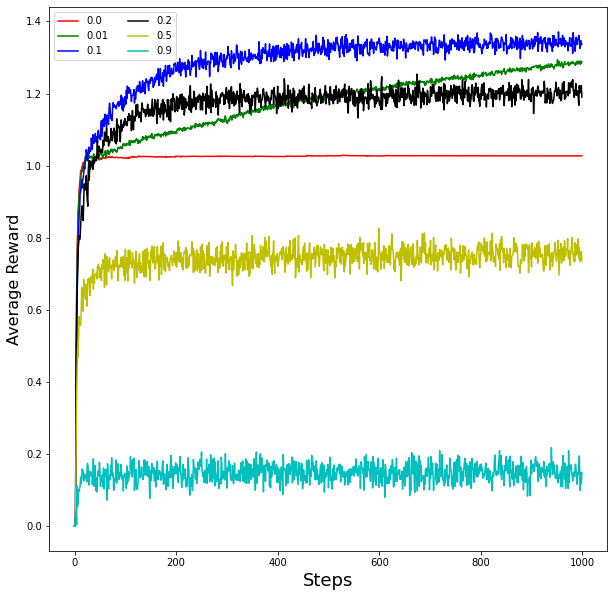

CPU times: user 187 ms, sys: 18.8 ms, total: 206 ms
Wall time: 1min 22s


In [42]:
%%time
with multiprocessing.Manager() as manager:
    global_reward_list = []
    mp_objects = []
    epsilon_list= [0.0, 0.01,0.1,0.2,0.5,0.9]
    color_list = ['r', 'g', 'b', 'k', 'y','c']
    for eps in epsilon_list:
        global_reward_list.append(manager.list())
        mp_objects.append(multiprocessing.Process(target=rewards_per_step_mp,args=(steps, n_bandit, n_lever, 
                                                                  testbed, initial_reward_estimates,
                                                                  eps,
                                                                global_reward_list[len(global_reward_list)-1])) )
    for index in range(len(mp_objects)):
        mp_objects[index].start()

    for index in range(len(mp_objects)):
        mp_objects[index].join()
    
    plt.figure(figsize=(10,10))
    plt.xlabel('Steps', fontsize=18)
    plt.ylabel('Average Reward', fontsize=16)
    for  index in range(len(mp_objects)):
        plt.plot(np.arange(steps),global_reward_list[index][0],label=epsilon_list[index], color=color_list[index])
    
    plt.legend(loc=2, ncol=2)
    
    plt.show()

## Lets do some more rearrangements

Earlier we have got the following equation :
\begin{equation*}
Q_{n+1} = \frac{1}{n} ( R_n +(n-1)Q_n )
\end{equation*}

With some more rearrangement, we can obtain following
\begin{equation*}
Q_{n+1} = Q_n + \frac{1}{n} [ R_n - Q_N ]
\end{equation*}

#### What is so important about this  equation ?
This Form of equation is frequently used in the book. The general form is :
 \begin{equation*}
NewEstimate \leftarrow  OldEstimate + StepSize [ Target - OldEstimate ]
\end{equation*}

The expression Target OldEstimate is an error in the estimate. It is reduced by taking a step toward the “Target.” The target is presumed to indicate a desirable direction in which to move, though it may be noisy.Note that the step-size parameter (StepSize) used in the above incremental method changes from time step to time step